# Sandboxing some pytorch and pyro stuff 

In [1]:
import torch
import numpy as np
import pyro

In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

## Pytorch Blitz

### What is pytorch?

let's omit this shit...

### AUTOGRAD: Automatic Differentiation

scalar function grad

In [92]:
x = torch.ones(2, 2, requires_grad=True)

In [93]:
y = x + 2

In [94]:
y.grad_fn

In [95]:
z = y*y*3

In [96]:
out=z.mean()

In [97]:
out

tensor(27., grad_fn=<MeanBackward0>)

In [98]:
out.backward(torch.tensor(2.))

In [99]:
print(x.grad)

tensor([[9., 9.],
        [9., 9.]])


vector function grad...

In [29]:
x=torch.tensor([1., 2., 3.], requires_grad=True)

In [30]:
y=2*x*x

In [31]:
v = torch.tensor([1., 1., 2.])
y.backward(v)
x.grad

tensor([ 4.,  8., 24.])

In [50]:
x = torch.tensor([[0., 0.], [1., 0]], requires_grad=True)


In [51]:
beta=1.
u = beta * ((x[0,:] - x[1,:]).norm(p=2) - 1.1)**2

In [52]:
u.backward()

In [53]:
x.grad

tensor([[ 0.2000,  0.0000],
        [-0.2000,  0.0000]])

for simplicity's sake, let's create a 1-dimensional potential...

In [32]:
x = torch.tensor([[0., 0.], [1., 0.], [0., 1.]], requires_grad=True)

In [ ]:
u = ()

## Intro to Pyro

In [2]:
import pyro
pyro.set_rng_seed(101)

In [12]:
#draw a sample from a standard normal
loc=0; scale=1.
normal=torch.distributions.Normal(loc, scale)
x=normal.rsample()
energy=-normal.log_prob(x)
print(x, energy)

tensor(-0.2520) tensor(0.9507)


In [13]:
def weather():
    cloudy=pyro.sample('cloudy', pyro.distributions.Bernoulli(0.3))
    cloudy='cloudy' if cloudy.item()==1. else 'sunny'
    mean_temp={'cloudy':55., 'sunny': 75.}['cloudy']
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = pyro.sample('temp', pyro.distributions.Normal(mean_temp, scale_temp))
    return cloudy, temp.item()

In [14]:
weather()

('sunny', 48.44023513793945)

In [7]:
def normal_product(loc, scale):
    z1 = pyro.sample("z1", pyro.distributions.Normal(loc, scale))
    z2 = pyro.sample("z2", pyro.distributions.Normal(loc, scale))
    y = z1 * z2
    return y

def make_normal_normal():
    mu_latent = pyro.sample("mu_latent", pyro.distributions.Normal(0, 1))
    fn = lambda scale: normal_product(mu_latent, scale)
    return fn

print(make_normal_normal()(1.))


tensor(0.4867)


### SVI part 1: an intro to stochastic variational inference in pyro

we define a joint distribution $$p(x, z | \theta) = p(x|z, \theta)p(z|\theta)$$
where we want to maximize the log evidence (i.e. $\log p(x|\theta)$

`model` is the posterior, whereas `guide` is a family of distributions $q_{\phi}(z)$ that can be optimized w.r.t. $\phi$ (i.e. the variational parameters).  To be concrete, we need to be able to compute the distribution of the latent variables given the data (aka the posterior)
$$p(z|x, \theta) = \frac {p(x, z | \theta)}  {\int dz p(x, z | \theta)}$$

#### ELBO (Evidence Lower Bound)

$$
ELBO =
\langle
\log p(x, z | \theta) - \log q_{\phi}(z)
\rangle
_{q_{\phi}(z)}
$$

### Class

in order to do VI, we use `SVI`, which supports ELBO optimization.<br>
The user needs to provide the model, the guide, and the optimizer...

```
import pyro
from pyro.infer import SVI, Trace_ELBO
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
```

### Simple Coin Example

you have a 2 sided coin and you want to determine whether it's fair; really, you are trying to determine the latent bias parameter;<br>
- encode heads and tails as 1 ,0 <br>
- the fairness is $f$, where $f \in \left[ 0.0, 1.0 \right]$
- our prior $p(f) = \text{Beta}(10, 10)$

In [3]:
xs = torch.linspace(0,1)
beta = pyro.distributions.Beta(10, 10)
log_probs = torch.tensor([beta.log_prob(x) for x in xs[1:-1]])

Text(0.5, 1.0, 'prior')

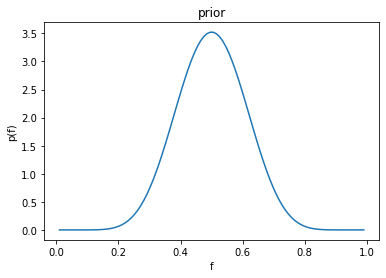

In [4]:
xs = torch.linspace(0,1)
beta = pyro.distributions.Beta(10, 10)
log_probs = torch.tensor([beta.log_prob(x) for x in xs[1:-1]])
plt.plot(xs[1:-1], np.exp(log_probs))
plt.xlabel('f')
plt.ylabel("p(f)")
plt.title(f"prior")

- let's say we have collected the data in a list; let's write the corresponding model..

In [5]:
import pyro.distributions as dist
import torch.distributions.constraints as constraints

In [6]:
def model(data):
    """
    the model is the product of the likelihood and the prior;
    define samples of the likelihood with `obs` arg for all of the data
    """
    alpha0 = torch.tensor(10.) #alpha hyperparam
    beta0 = torch.tensor(10.) #beta hyperparam
    
    #sample an f from the prior given prior hyperparams
    f = pyro.sample('latent fairness', dist.Beta(alpha0, beta0))
    
    for i in range(len(data)):
        pyro.sample(f"obs_{i}", dist.Bernoulli(f), obs=data[i])
    

In [7]:
def guide(data):
    """
    define a guide, which is a family of distributions on the latent variables
    that is parameterized by `\phi` variables
    """
    #in this case, we are going to optimize 2 parameters: alpha_q and beta_q
    #and the parameters will parameterize a family of distributions of the beta form
    
    alpha_q = pyro.param('alpha_q', torch.tensor(15.), constraint=constraints.positive)
    beta_q = pyro.param('beta_q', torch.tensor(15.), constraint=constraints.positive)
    
    #and just sample the latent fairness from the distribution
    pyro.sample('latent_fairness', dist.Beta(alpha_q, beta_q))
    

Note:
- the model and the guide have the same latent variable names
- the model is not an explicit function of the latent variable, but instead set by data
- the guide also holds `data` arguments
- the variational parameters are torch tensors, and `pyro.param` automatically sets `requires_grad` to `True`
- we put positive constraints on the variational parameters

now we can to Stochastic Variational Inference (SVI)

In [8]:
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import tqdm

we just need to add some data first...

In [9]:
data = []
for _ in range(6):
    data.append(torch.tensor(1.))
for _ in range(4):
    data.append(torch.tensor(0.))


In [33]:
adam_params = {'lr': 5e-4, 'betas': (0.9, 0.999)}
optimizer=Adam(adam_params)

svi=SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps=5000
for step in tqdm.trange(n_steps):
    svi.step(data)

100%|██████████| 5000/5000 [00:27<00:00, 179.61it/s]


In [38]:
alpha_q = pyro.param('alpha_q').item()
beta_q = pyro.param('beta_q').item()
# here we use some facts about the beta distribution
# compute the inferred mean of the coin's fairness
inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * np.sqrt(factor)

print("\nbased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))


based on the data and our prior belief, the fairness of the coin is 0.502 +- 0.258


### SVI part 2: conditional independence, subsampling, and amortization

for models with N observables, running `model` and `guide` requires `ELBO` estimates that scales poorly with N; but we can subsample in batches provided that there are some conditional independencies that we can take advantage of.  <br>

For example, if the observations are conditionally independent given latent variables, the log likelihood can be approximated as
$$
\sum_{i=1}^{N}\ln p(x_i|z) \approx \frac{N}{M} \sum_{i \in I_M} \ln p(x_i|z)
$$
where $I_M$ is a minibatch of the N data points

for some reason in pyro, it is necessary to explcitly replace the `for` loop in `model` (the one that adds the data as `obs`)

In [10]:
def model(data):
    """
    the model is the product of the likelihood and the prior;
    define samples of the likelihood with `obs` arg for all of the data
    """
    alpha0 = torch.tensor(10.) #alpha hyperparam
    beta0 = torch.tensor(10.) #beta hyperparam
    
    #sample an f from the prior given prior hyperparams
    f = pyro.sample('latent fairness', dist.Beta(alpha0, beta0))
    
#     for i in range(len(data)):
#         pyro.sample(f"obs_{i}", dist.Bernoulli(f), obs=data[i])

    #the above code has to be replaced with 
    for i in pyro.plate('data_loop', len(data)):
        pyro.sample(f"obs_{i}", dist.Bernoulli(f), obs=data[i])

as a note, you can also vectorize `plate` like such:<br>
```
data=torch.zeros(10)
data[:6]=torch.ones()
with plate('observed_data'):
    pyro.sample('obs', dist.Bernoulli(f), obs=data)
```

#### subsamping

subsample to run on large datasets...<br>
simply put, we can just subsample in the plate...<br>
```
for i in pyro.plate("data_loop", len(data), subsample_size=5):
    pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])
```
which,by the way, does automatic scaling;<br>
this can also be vectorized...<br>
```
with plate('observe_data', size=10, subsample_size=5) as ind:
    pyro.sample('obs', dist.Bernoulli(f),
                obs=data.index_select(0, ind))
```
However, if the data size is really big, theres a nonnegligible probability tat some dat apoints will never have been subsampled; you can use the `subsample` argument in `plate`